<a href="https://www.kaggle.com/code/keilamoral/avast-ctu-cape?scriptVersionId=222227705" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Avast-CTU Public CAPEv2 Dataset

There is a limited amount of publicly available data to support research in malware analysis technology. Particularly, there are virtually no publicly available datasets generated from rich sandboxes such as Cuckoo/CAPE. 

The benefit of using dynamic sandboxes is the realistic simulation of file execution in the target machine and obtaining a log of such execution. The machine can be infected by malware hence there is a good chance of capturing the malicious behavior in the execution logs,  thus allowing researchers to study such behavior in detail. Although the subsequent analysis of log information is extensively covered in industrial cybersecurity backends, to our knowledge there has been only limited effort invested in academia to advance such log analysis capabilities using cutting edge techniques. 

We make this sample dataset available to support designing new machine learning methods for malware detection, especially for automatic detection of generic malicious behavior. The dataset has been collected in cooperation between Avast Software and Czech Technical University - AI Center (AIC).
​
The archive contains CAPEv2 reports of 48,976 malicious files. For each file, we provide the following metadata:
* sha256,
* classification to malware family,
* type of the malware,
* date of detection of the file.
  
There are 6 types of malware ( "banker", "trojan", "pws", "coinminer", "rat", "keylogger") and 10 malware families in the dataset:
​
| Malware Family Name | Number of Samples |
| ------------------- | ----------------- |
| Adload              | 704               |
| Emotet              | 14,429            |
| HarHar              | 655               |
| Lokibot             | 4,191             |
| njRAT               | 3,372             |
| Qakbot              | 4,895             |
| Swisyn              | 12,591            |
| Trickbot            | 4,202             |
| Ursnif              | 1,343             |
| Zeus                | 2,594             |


In [35]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import os

In [36]:
# Loading dataset
avast_ctu_dataset = pd.read_csv('/kaggle/input/avast-ctu-dataset/public_labels.csv')

# Modifying dataset
family_type_mapping = {
    'Adload': 0, 'Emotet': 1, 'HarHar': 2, 'Lokibot': 3, 'njRAT': 4,
    'Qakbot': 5, 'Swisyn': 6, 'Trickbot': 7, 'Ursnif': 8, 'Zeus': 9
}
avast_ctu_dataset["family_type"] = avast_ctu_dataset['classification_family'].map(family_type_mapping).fillna(10).astype(int)

malware_type_mapping = {
    'banker': 0, 'trojan': 1, 'pws': 2, 'coinminer': 3, 'rat': 4,
    'keylogger': 5
}
avast_ctu_dataset["malware_type"] = avast_ctu_dataset['classification_type'].map(malware_type_mapping).fillna(6).astype(int)
avast_ctu_dataset.head()
avast_ctu_dataset['date'] = pd.to_datetime(avast_ctu_dataset['date'])
avast_ctu_dataset = avast_ctu_dataset.sort_values(by='date')
avast_ctu_dataset.head()


,sha256,classification_family,classification_type,date,family_type,malware_type
9271,302014bd83749d0a44c98a2546e30a030bb0770713719b...,Zeus,banker,2008-06-26,9,0
21683,70e1d2fba60a7d20e531b09ff328fef21b82bb7e87d78a...,Zeus,banker,2011-10-15,9,0
21257,6e96f8e3e704e6752bf03527dcb3057bd9e51892cc1c74...,Zeus,banker,2011-10-25,9,0
16108,536fe6ef2f49f93f7ca858fa3864a93a34804f32b14945...,Zeus,banker,2011-10-30,9,0
6983,245d79018a49e1d49ba5e470d13b521f5f1b8dc5f942d6...,Zeus,banker,2011-11-13,9,0


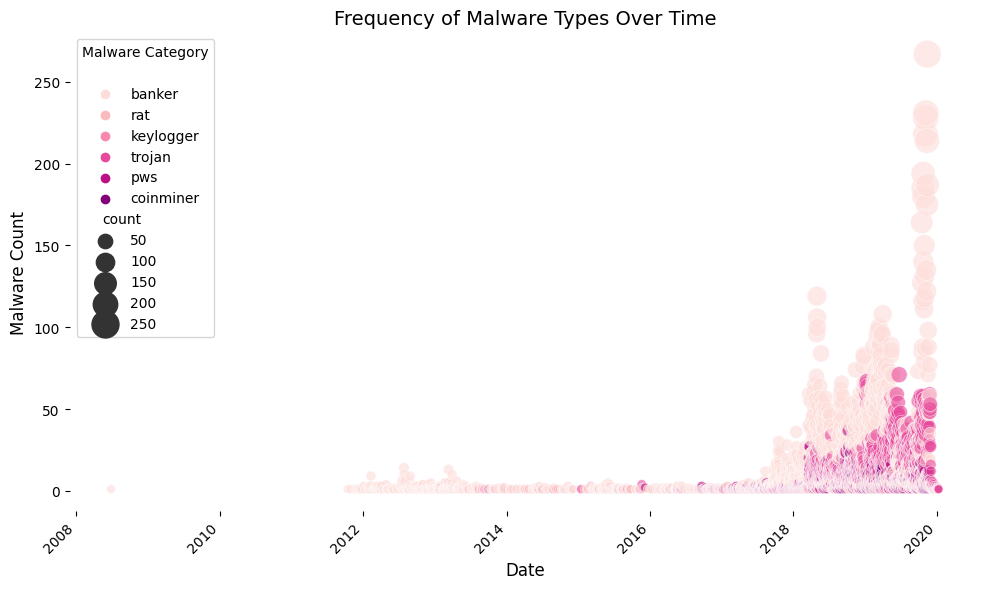

In [37]:
def plot_malware_frequency(df):
    """
    Plots the frequency of malware types over time using a scatter plot.

    Args:
        df (pd.DataFrame): DataFrame containing 'date' and 'malware_type' columns.
                           'date' should be in a format that pandas can understand (e.g., 'YYYY-MM-DD').
    """

    # Aggregate malware counts by date and type
    malware_counts = avast_ctu_dataset.groupby(['date', 'classification_type']).size().reset_index(name='count')

    # Scatter Plot
    f, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
    sns.despine(f, left=True, bottom=True)  # Remove unnecessary spines

    pink_palette = sns.color_palette("RdPu", n_colors=len(avast_ctu_dataset['classification_type'].unique()))

    sns.scatterplot(x="date", y="count",
                    hue="classification_type",  # Color points by malware type
                    size="count",       # Size of points based on count
                    sizes=(40, 400),    # Adjust size range as needed
                    alpha=0.6,          # Add some transparency
                    data=malware_counts,
                    palette = pink_palette,
                    ax=ax)
    data = {'date': avast_ctu_dataset["date"],
            'malware_type': avast_ctu_dataset["classification_type"]}
    
    #sns.kdeplot(data=avast_ctu_dataset["date"], y='count', ax=ax, color='r', legend=False)
    
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Malware Count", fontsize=12)
    ax.set_title("Frequency of Malware Types Over Time", fontsize=14)

    plt.xticks(rotation=45, ha="right") 
    
    #plt.legend(title="Malware Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    leg = ax.get_legend()
    
    # Set the new title for the legend
    leg.set_title("Malware Category")
    for t in leg.texts:
        if t.get_text() == 'classification_type':
            t.set_text('')

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

plot_malware_frequency(avast_ctu_dataset["date"] )

